In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import time
from tensorflow.keras.models import model_from_json


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
DATADIR = os.path.join(os.getcwd(),"repair1","train")
TESTDIR = os.path.join(os.getcwd(),"repair1","test")
CATEGORIES = ["defect","normal"]
IMG_SIZE = 128
X,X_test,y,y_test = [],[],[],[]

TIME = int(time.time())
tensorboard = TensorBoard(log_dir = 'logs/model-{}'.format(TIME))

In [3]:
def load_data(X,X_test,y,y_test):
    for category in CATEGORIES:
        class_num = CATEGORIES.index(category)
        path = os.path.join(DATADIR,category)
        test_path = os.path.join(TESTDIR,category)
        
        sorted_list = os.listdir(path)
        sorted_list.sort()
        for img in sorted_list:
            if img.endswith(".jpg"):
                img_array =cv2.imread(os.path.join(path,img),0)
                new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
                X.append(new_array)
                y.append(class_num)
                
                
        sorted_list = os.listdir(test_path)
        sorted_list.sort()
        
        for img in sorted_list:
            if img.endswith(".jpg"):
                img_array =cv2.imread(os.path.join(test_path,img),0)
                new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))

                X_test.append(new_array)
                y_test.append(class_num)

    H = np.array(X[::2]).reshape(-1,IMG_SIZE,IMG_SIZE)
    V = np.array(X[1::2]).reshape(-1,IMG_SIZE,IMG_SIZE)
    HV = H-V
    X = np.stack((H,V, HV), axis=3)
    
    y = y[::2]
    y_test = y_test[::2]

    H = np.array(X_test[::2]).reshape(-1,IMG_SIZE,IMG_SIZE)
    V = np.array(X_test[1::2]).reshape(-1,IMG_SIZE,IMG_SIZE)
    HV = H - V
    X_test = np.stack((H,V,HV), axis=3)
        
    print(X.shape)
    print(len(y))
    print(X_test.shape)
    print(len(y_test))
    return (X,X_test,y,y_test)
(X,X_test,y,y_test) = load_data(X,X_test,y,y_test)


(4428, 128, 128, 3)
4428
(4816, 128, 128, 3)
4816


In [4]:
print(y_test[:42])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [5]:
print(len(X))
X = normalize(X)
print(X.shape)
X_test = normalize(X_test)


4428
(4428, 128, 128, 3)


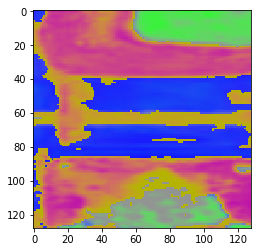

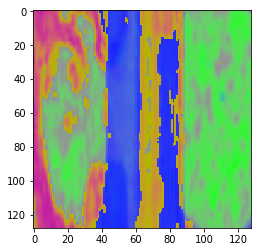

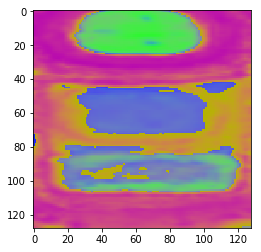

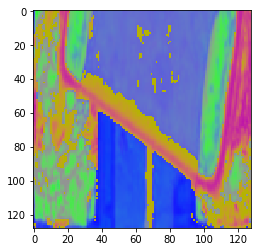

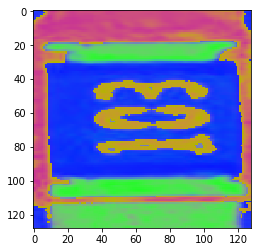

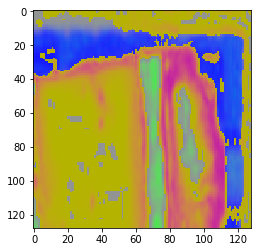

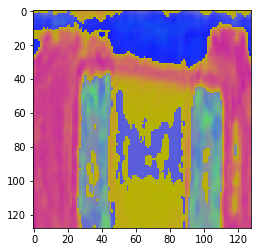

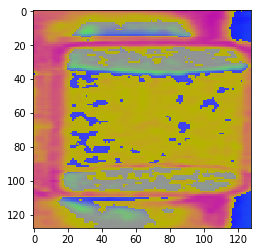

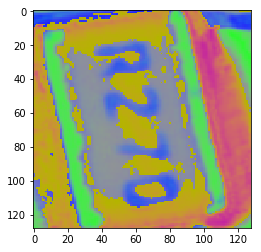

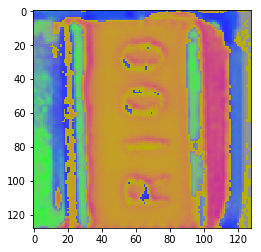

In [6]:
for i in range(10):
    plt.imshow(X[i])
    plt.show()

In [ ]:
def inception_v2():
    input_layer = Input(shape = (IMG_SIZE,IMG_SIZE,3))
    
    conv_1 = Conv2D(32, (3,3), padding='same', activation='relu')(input_layer)
    pool = MaxPooling2D((2,2))(conv_1)
    conv_2 = Conv2D(64,(3,3), padding='same',activation='relu')(pool)
    pool_0 = MaxPooling2D((2,2))(conv_2)
    
    layer_1 = Conv2D(96, (1,1), padding='same', activation='relu')(pool_0)
    layer_1 = Conv2D(64, (3,3), padding='same', activation='relu')(layer_1)

    layer_2 = Conv2D(16, (1,1), padding='same', activation='relu')(pool_0)
    layer_2 = Conv2D(32, (3,3), padding='same', activation='relu')(layer_2)
    layer_2 = Conv2D(32, (3,3), padding='same', activation='relu')(layer_2)

    layer_3 = MaxPooling2D((1,1), strides=(1,1), padding='same')(pool_0)
    layer_3 = Conv2D(32, (1,1), padding='same', activation='relu')(layer_3)
    
    layer_4 = Conv2D(64, (1,1), padding= 'same', activation='relu')(pool_0)

    mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3,layer_4], axis = 3)
    pool_1 = MaxPooling2D((2,2))(mid_1)
    
    layer_1 = Conv2D(96, (1,1), padding='same', activation='relu')(pool_1)
    layer_1 = Conv2D(64, (3,3), padding='same', activation='relu')(layer_1)

    layer_2 = Conv2D(16, (1,1), padding='same', activation='relu')(pool_1)
    layer_2 = Conv2D(32, (3,3), padding='same', activation='relu')(layer_2)
    layer_2 = Conv2D(32, (3,3), padding='same', activation='relu')(layer_2)

    layer_3 = MaxPooling2D((1,1), strides=(1,1), padding='same')(pool_1)
    layer_3 = Conv2D(32, (1,1), padding='same', activation='relu')(layer_3)
    
    layer_4 = Conv2D(64, (1,1), padding= 'same', activation='relu')(pool_1)
    

    
    mid_2 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4], axis = 3)
    pool_2 = MaxPooling2D((2,2))(mid_2)
    

    
    
    layer_1 = Conv2D(96, (1,1), padding='same', activation='relu')(pool_2)
    layer_1 = Conv2D(64, (3,3), padding='same', activation='relu')(layer_1)

    layer_2 = Conv2D(16, (1,1), padding='same', activation='relu')(pool_2)
    layer_2 = Conv2D(32, (3,3), padding='same', activation='relu')(layer_2)
    layer_2 = Conv2D(32, (3,3), padding='same', activation='relu')(layer_2)

    layer_3 = MaxPooling2D((1,1), strides=(1,1), padding='same')(pool_2)
    layer_3 = Conv2D(32, (1,1), padding='same', activation='relu')(layer_3)
    
    layer_4 = Conv2D(64, (1,1), padding= 'same', activation='relu')(pool_2)
    
    mid_3 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4], axis = 3)
    pool_3 = MaxPooling2D((2,2))(mid_3)
    

    

    
    
    flat = Flatten()(pool_3)
    drop_1 = Dropout(0.6)(flat)
    FC_6 = Dense(1200, activation='relu')(drop_1)


    output_layer = Dense(1, activation = 'sigmoid') (FC_6)
    model = Model(input_layer,output_layer)

    model.summary()

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

model = inception_v2()
history = model.fit(X,y,epochs=100, validation_data=(X_test,y_test), callbacks=[tensorboard], class_weight={0:30,1:1} )

W0926 05:31:12.701813 140662104372992 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0926 05:31:13.414352 140662104372992 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0926 05:31:13.552656 140662104372992 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

W0926 05:31:21.622056 140662104372992 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.113952). Check your callbacks.


4428/4428 [==============================] - 21s 5ms/sample - loss: 1.9675 - acc: 0.3281 - val_loss: 0.7225 - val_acc: 0.0042
Epoch 2/100
4428/4428 [==============================] - 18s 4ms/sample - loss: 1.4130 - acc: 0.3482 - val_loss: 0.6415 - val_acc: 0.6476
Epoch 3/100
4428/4428 [==============================] - 18s 4ms/sample - loss: 1.4126 - acc: 0.4365 - val_loss: 0.8630 - val_acc: 0.1285
Epoch 4/100
4428/4428 [==============================] - 18s 4ms/sample - loss: 1.2392 - acc: 0.6771 - val_loss: 1.4410 - val_acc: 0.0750
Epoch 5/100
4428/4428 [==============================] - 18s 4ms/sample - loss: 1.0663 - acc: 0.7396 - val_loss: 0.5942 - val_acc: 0.7496
Epoch 6/100
4428/4428 [==============================] - 18s 4ms/sample - loss: 0.9013 - acc: 0.8482 - val_loss: 0.7362 - val_acc: 0.6588
Epoch 7/100
4428/4428 [==============================] - 18s 4ms/sample - loss: 0.7440 - acc: 0.8600 - val_loss: 0.5839 - val_acc: 0.7930
Epoch 8/100
4428/4428 [=======================

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
def generate_classification_report(images,labels,model):
    pred = np.array(model.predict(images))
    pred = np.reshape(pred,len(labels))
    pred = pred.astype(int)
    labels = np.array(labels)
    return classification_report(labels,pred)
y_pred = np.array(model.predict(X_test))

y_pred = np.reshape(y_pred,(4816))
y_pred = y_pred.astype(int)

y_test = np.array(y_test)
print(classification_report(y_test, y_pred,target_names=["defect","normal"]))

y_pred = np.array(model.predict(X))
y_pred = np.reshape(y_pred,(4428))
y_pred = y_pred.astype(int)
y = np.array(y)
print(classification_report(y,y_pred,target_names=["defect","normal"]))